In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import time

# Data Pulling


In [2]:
artists = pd.read_csv('data/input/artists_reduced.csv')
designers = pd.read_csv('data/input/designers_reduced.csv')
games = pd.read_csv('data/input/games.csv')
mechanics = pd.read_csv('data/input/mechanics.csv')
publishers = pd.read_csv('data/input/publishers_reduced.csv')
ratings_dist = pd.read_csv('data/input/ratings_distribution.csv')
subcategories = pd.read_csv('data/input/subcategories.csv')
themes = pd.read_csv('data/input/themes.csv')
user_ratings = pd.read_csv('data/input/user_ratings.csv')

# Data Transformation

## Artists
- BGG ID
- Low-Exp artists indicates the game has an unlisted artist w/ < 3 games
- 1 column per artist name (1/0 indicates the artist)

**Transformation needed: sum all columns all to get the total number of artists that worked on the game**

In [3]:
artists.head()

,Harald Lieske,Franz Vohwinkel,Peter Whitley,Scott Okumura,(Uncredited),Doris Matthäus,Alan R. Moon,Alexander Jung,Andrea Boekhoff,Björn Pertoft,...,Nathan Meunier,Andrey Gordeev,Zbigniew Umgelter,Jeppe Norsker,Daniel Profiri,Aleksander Zawada,Simon Douchy,Felix Wermke,BGGId,Low-Exp Artist
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [4]:
# creating column indicating how many artists worked on the game
cols = [c for c in artists.columns if c not in ['BGGId','Low-Exp Artist']]
artists['total_artists_contributed'] = artists[cols].sum(axis=1)

In [5]:
final_artists = artists[['BGGId','Low-Exp Artist','total_artists_contributed']]
final_artists.head()

,BGGId,Low-Exp Artist,total_artists_contributed
0,1,1,1
1,2,1,0
2,3,0,1
3,4,1,0
4,5,0,2


## Designers
- Same structure as artists

**Transformation needed: sum all columns all to get the total number of designers that worked on the game**

In [6]:
designers.head()

,Karl-Heinz Schmiel,"G. W. ""Jerry"" D'Arcey",Reiner Knizia,Sid Sackson,Jean du Poël,Martin Wallace,Richard Ulrich,Wolfgang Kramer,Alan R. Moon,Uwe Rosenberg,...,Thomas Dupont,Mathieu Casnin,Sean Fletcher,Moritz Dressler,Molly Johnson,Robert Melvin,Shawn Stankewich,Nathan Meunier,BGGId,Low-Exp Designer
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [7]:
# creating column indicating how many artists worked on the game
cols = [c for c in designers.columns if c not in ['BGGId','Low-Exp Designer']]
designers['total_designers_contributed'] = designers[cols].sum(axis=1)

In [8]:
final_designers = designers[['BGGId','Low-Exp Designer','total_designers_contributed']]

In [9]:
final_designers.head()

,BGGId,Low-Exp Designer,total_designers_contributed
0,1,0,1
1,2,0,1
2,3,0,1
3,4,1,0
4,5,0,1


## Games
**Transformation needed: remove columns like name & description that will not be used in clustering**

In [10]:
games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,21926,0,1,0,0,0,0,0,0
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,...,21926,21926,0,0,0,0,0,0,0,0
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,...,21926,21926,0,1,0,0,0,0,0,0


In [11]:
suppressed_columns =['Name','Description','Family','GoodPlayers', 'ImagePath']
final_cols = [c for c in games.columns if c not in suppressed_columns]

final_games = games[final_cols]
final_games.head()

,BGGId,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,1986,4.3206,7.61428,7.10363,1.57979,3,5,14.366667,1.395833,...,21926,21926,0,1,0,0,0,0,0,0
1,2,1981,1.9630,6.64537,5.78447,1.45440,3,4,NaN,27.000000,...,21926,21926,0,1,0,0,0,0,0,0
2,3,1998,2.4859,7.45601,7.23994,1.18227,2,4,9.307692,1.000000,...,21926,21926,0,1,0,0,0,0,0,0
3,4,1992,2.6667,6.60006,5.67954,1.23129,2,4,13.000000,256.000000,...,21926,21926,0,0,0,0,0,0,0,0
4,5,1964,2.5031,7.33861,7.14189,1.33583,2,6,11.410256,21.152941,...,21926,21926,0,1,0,0,0,0,0,0


# Mechanics

**Keeping all mechanics for clustering process**

In [12]:
mechanics.head()

,BGGId,Alliances,Area Majority / Influence,Auction/Bidding,Dice Rolling,Hand Management,Simultaneous Action Selection,Trick-taking,Hexagon Grid,Once-Per-Game Abilities,...,Contracts,Passed Action Token,King of the Hill,Action Retrieval,Force Commitment,Rondel,Automatic Resource Growth,Legacy Game,Dexterity,Physical
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Publishers
**Keeping all publishers for clustering process**

In [13]:
publishers.head()

,Hans im Glück,Moskito Spiele,Portal Games,Spielworxx,Stronghold Games,"Valley Games, Inc.",YOKA Games,sternenschimmermeer,E.S. Lowe,Milton Bradley,...,Cacahuete Games,BlackSands Games,Norsker Games,Perro Loko Games,Funko Games,Origame,Deep Print Games,Hidden Industries GmbH,BGGId,Low-Exp Publisher
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,2,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1


## Rating Distribution

**Transformation needed: bucket the ratings at whole numbers**

In [14]:
ratings_dist.head()

,BGGId,0.0,0.1,0.5,1.0,1.1,1.2,1.3,1.4,1.5,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,total_ratings
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,5.0,11.0,86.0,3.0,4.0,6.0,8.0,426.0,5352.0
1,2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,17.0,562.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,7.0,4.0,77.0,3.0,1.0,5.0,3.0,477.0,15148.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,342.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,8.0,4.0,82.0,7.0,9.0,10.0,5.0,905.0,18387.0


In [15]:
for i in list(range(0,11)):
    converted_cols = [c for c in ratings_dist.columns if c not in ['BGGId','total_ratings'] and 'bucket' not in c]
    cols = [c for c in converted_cols if float(c) >= i and float(c) < i+1]
    ratings_dist['rating_bucket_'+str(i)] = ratings_dist[cols].sum(axis=1)
final_ratings_dist = ratings_dist[[c for c in ratings_dist.columns if 'bucket' in c or c in ['BGGId','total_ratings']]]

In [16]:
final_ratings_dist.head()

,BGGId,total_ratings,rating_bucket_0,rating_bucket_1,rating_bucket_2,rating_bucket_3,rating_bucket_4,rating_bucket_5,rating_bucket_6,rating_bucket_7,rating_bucket_8,rating_bucket_9,rating_bucket_10
0,1,5352.0,0.0,0.0,24.0,60.0,92.0,231.0,628.0,1312.0,1598.0,981.0,426.0
1,2,562.0,0.0,3.0,2.0,9.0,19.0,75.0,162.0,157.0,83.0,35.0,17.0
2,3,15148.0,0.0,0.0,0.0,16.0,170.0,506.0,2039.0,5505.0,4807.0,1628.0,477.0
3,4,342.0,0.0,0.0,0.0,5.0,10.0,44.0,109.0,107.0,49.0,15.0,3.0
4,5,18387.0,0.0,0.0,0.0,0.0,56.0,945.0,2996.0,6587.0,4952.0,1946.0,905.0


## Subcategories 

No transformation needed

In [17]:
subcategories.head()

,BGGId,Exploration,Miniatures,Territory Building,Card Game,Educational,Puzzle,Collectible Components,Word Game,Print & Play,Electronic
0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0


## Themes

No transformation needed

In [18]:
themes.head()

,BGGId,Adventure,Fantasy,Fighting,Environmental,Medical,Economic,Industry / Manufacturing,Transportation,Science Fiction,...,Theme_Fashion,Theme_Geocaching,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## User ratings

**Transformation needed: aggregate ratings per game**

In [19]:
user_ratings.head()

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


In [20]:
final_user_ratings = user_ratings.groupby('BGGId').agg({'Rating': ['mean','median','min', 'max','std']})
final_user_ratings = final_user_ratings.droplevel(level=0,axis=1).reset_index()

names_dict = dict = {
        'mean': 'rating_average',
        'median': 'rating_median',
        'min': 'rating_min',
        'max': 'rating_max',
        'std': 'rating_std'}

final_user_ratings.rename(columns=names_dict,inplace=True)

In [21]:
final_user_ratings.head()

,BGGId,rating_average,rating_median,rating_min,rating_max,rating_std
0,1,7.672014,8.0,2.0,10.0,1.468025
1,2,6.642697,7.0,1.0,10.0,1.472245
2,3,7.484350,7.5,3.0,10.0,1.117447
3,4,6.599476,7.0,3.0,10.0,1.230103
4,5,7.439818,7.3,4.0,10.0,1.174464


# Final Dataset

In [22]:
df = final_games.merge(final_artists,on='BGGId',how='left')
df = df.merge(final_designers,on='BGGId',how='left')
df = df.merge(final_ratings_dist,on='BGGId',how='left')
df = df.merge(final_user_ratings,on='BGGId',how='left')
df = df.merge(mechanics,on='BGGId',how='left')
df = df.merge(publishers,on='BGGId',how='left')
df = df.merge(subcategories,on='BGGId',how='left')
df = df.merge(themes,on='BGGId',how='left')

In [23]:
# df.columns[df.isna().any()].tolist()
df[df.columns[df.isna().any()].tolist()].isnull().sum()

ComAgeRec       5530
LanguageEase    5891
dtype: int64

In [24]:
# Fill NAs
df = df.fillna(0)

In [25]:
df[df.columns[df.isna().any()].tolist()].isnull().sum()

Series([], dtype: float64)

In [26]:
df.to_csv('data/output/final_data_combined.csv')

# PCA
- Lower dimensionality as we have 2K columns

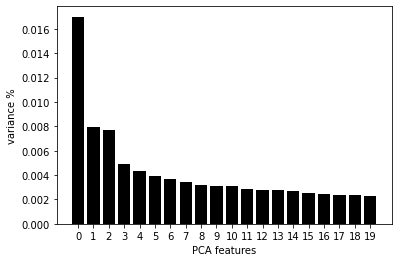

In [27]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(d)
# ks = range(1, 10)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters: model
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(scaled_features)
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()

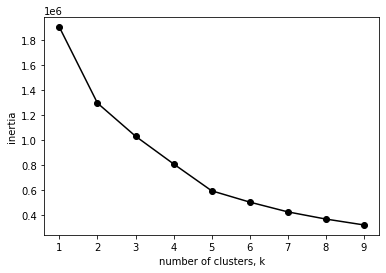

In [28]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:4])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [29]:
kmeans_pca = KMeans(
     init="random",
     n_clusters=7,
     n_init=10,
     max_iter=300,
     random_state=42
 )

In [30]:
kmeans_pca.fit(PCA_components.iloc[:,:10])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=7,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [31]:
df['cluster'] = kmeans_pca.labels_

In [32]:
df.cluster.value_counts()

0    15391
1     4599
2     1714
6      181
3       18
4       17
5        5
Name: cluster, dtype: int64

In [33]:
df = df.merge(games[['BGGId','Name']],on='BGGId',how='left')

In [34]:
df.head()

,BGGId,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,...,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification,cluster,Name
0,1,1986,4.3206,7.61428,7.10363,1.57979,3,5,14.366667,1.395833,...,0,0,0,0,0,0,0,0,2,Die Macher
1,2,1981,1.9630,6.64537,5.78447,1.45440,3,4,0.000000,27.000000,...,0,0,0,0,0,0,0,0,0,Dragonmaster
2,3,1998,2.4859,7.45601,7.23994,1.18227,2,4,9.307692,1.000000,...,0,0,0,0,0,0,0,0,2,Samurai
3,4,1992,2.6667,6.60006,5.67954,1.23129,2,4,13.000000,256.000000,...,0,0,0,0,0,0,0,0,0,Tal der Könige
4,5,1964,2.5031,7.33861,7.14189,1.33583,2,6,11.410256,21.152941,...,0,0,0,0,0,0,0,0,2,Acquire


In [35]:
df.to_csv("data/output/final_data_with_clusters.csv")

## Similarity Score

In [36]:
cols = [c for c in df.columns if c not in ['cluster','Name','BGGId']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[cols])

In [37]:
cluster_dict = df.set_index('Name').to_dict()['cluster']

In [38]:
len(cluster_dict)

21521

In [39]:
# similarities = cosine_similarity(scaled_features.transpose()) 

In [40]:
sims = cosine_similarity(df[cols])

In [41]:
np.shape(sims)

(21925, 21925)

In [42]:
# np.shape(similarities)

In [43]:
name_mapping = df[['Name']]

In [44]:
name_mapping

,Name
0,Die Macher
1,Dragonmaster
2,Samurai
3,Tal der Könige
4,Acquire
...,...
21920,Salvage
21921,Blitzkrieg!: World War Two in 20 Minutes
21922,Rock Paper Scissors: Deluxe Edition
21923,Splitter


In [45]:
cosine_sims = pd.DataFrame(sims)

In [46]:
cosine_sims = name_mapping.join(cosine_sims)

In [47]:
cosine_sims.rename(columns=name_mapping.to_dict()['Name'],inplace=True)

## Only keep similarities for games within same cluster

In [55]:
cosine_sims['cluster'] = df['Name'].map(cluster_dict)

In [56]:
cosine_sims = cosine_sims.loc[:,~cosine_sims.columns.duplicated()]

In [60]:
cosine_sims.head()

,Name,Die Macher,Dragonmaster,Samurai,Tal der Könige,Acquire,Mare Mediterraneum,Cathedral,Lords of Creation,El Caballero,...,System Gateway (fan expansion for Android: Netrunner),Voll verplant,Mille Fiori,7 Wonders: Architects,Azul: Queen's Garden,Salvage,Rock Paper Scissors: Deluxe Edition,Splitter,Captains' War,cluster
0,Die Macher,1.000000,-1.000000,-1.000000,-1.000000,0.930095,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.853611,0.919725,-1.000000,-1.0,-1.000000,-1.0,2
1,Dragonmaster,-1.000000,1.000000,0.909526,0.944848,-1.000000,0.940081,0.863342,0.942319,0.999336,...,0.942782,0.943487,0.942381,-1.000000,-1.000000,0.934773,-1.0,0.935360,-1.0,0
2,Samurai,-1.000000,0.909526,1.000000,0.846754,-1.000000,0.833558,0.822243,0.839399,0.922415,...,0.837494,0.839818,0.837631,-1.000000,-1.000000,0.825534,-1.0,0.826697,-1.0,0
3,Tal der Könige,-1.000000,0.944848,0.846754,1.000000,-1.000000,0.996249,0.928511,0.998166,0.941915,...,0.998637,0.999192,0.998280,-1.000000,-1.000000,0.991241,-1.0,0.991792,-1.0,0
4,Acquire,0.930095,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.750558,0.795474,-1.000000,-1.0,-1.000000,-1.0,2


In [61]:
all_games = [c for c in cosine_sims.columns if c != 'Name' and c != 'cluster']

In [65]:
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
# adjust similarities for games in different clusters
for game in all_games:
    print(game)
    target_cluster = cluster_dict[game]
    cosine_sims[game] = np.where(cosine_sims['cluster'] == target_cluster, cosine_sims[game], -1)
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

14:30:00
Die Macher
Dragonmaster
Samurai
Tal der Könige
Acquire
Mare Mediterraneum
Cathedral
Lords of Creation
El Caballero
Elfenland
Bohnanza
Ra
Catan
Basari
Cosmic Encounter
MarraCash
Button Men
RoboRally
Wacky Wacky West
Full Metal Planète
Gateway to the Stars
Magic Realm
Divine Right
Twilight Imperium
Battlemist
Age of Renaissance
Supremacy: The Game of the Superpowers
Illuminati
Terrain Vague
Dark Tower
Dark World
Buffalo Chess
Arkham Horror
Federation & Empire
Dragon Masters
Runes
Darkover
Borderlands
Can't Stop
Tigris & Euphrates
Airlines
David & Goliath
Perudo
Medici
Chinatown
Krieg und Frieden
Mamma Mia!
Lost Cities
Ricochet Robots
Mighty Empires
Brauerei
Tikal
Sophie's World
Schoko & Co.
Kings & Things
Giganten
Vinci
Fossil
Curse of the Mummy's Tomb
Samurai: Game of Politics and Warfare in Feudal Japan
Joan of Arc
Löwenherz
Conquest
Successors (First/Second Edition)
Bollox
Big City
Civilization
Verräter
Show Manager
Apples to Apples
Falling
Air Baron
EastFront
WestFront: The 

Crimean War Battles
Taipei: China Invades
Dragonhunt
Thunder Road
Buffy the Vampire Slayer: The Game
West Riding
Pipeline: The Oil Game
Amoeba
Rummikub
Goosebumps: Terror in the Graveyard Game
Aquarius
Chrononauts
2038: Tycoons of the Asteroid Belt
Quacksalbe
Axiom
La Trel
Carcassonne
The Lord of the Rings
Hijara
Screaming Eagles
Cartagena
Attila
Wizards
Battle of the Bands
Schrille Stille
For the People
Chronology
Election
New England Railways
Corsairs
Razzia
Circus Minimus
Mausoleum
Feudal
Tip Tap
Golf Masters
Pop Belly
...und tschüss!
Doge
Java
New York, New York
Titanic: Der Mythos
Blindes Huhn
Scotland the Brave
Weapons & Warriors:  Castle Combat Set
Mage Knight
Landslide
Lie, Cheat & Steal
Morisi
Bongo!
Empires of the Ancient World
Fire
M
Offline
Roads & Boats
Tennis Masters
Troia
Wyatt Earp
Tacara
Derby
Ivanhoe
Way Out West
Der Garten des Sonnenkönigs
Real Action Stockcar Championship
Cranium
APBA Pro Baseball
Movie Mania
City
Meuterer
Hamsterrolle
Dream Factory
Vagabondo
Abilen

Mississippi
Devil Bunny Hates the Earth
Proton
Z-G
Grant Takes Command
Wilderness War
1829
Trump: The Game
Whatzit?
Chainsaw Warrior
Risk 2210 A.D.
Nippon Rails
North American Rails
Spree!
The Willow Game
Scrutineyes
Solarquest
Word Yahtzee
Battle of Britain
Hägar ruft zum Beutefest
Hedbanz for Adults!
Time War: A Game of Time Travel and Conflict
Doomtrooper
Dragon Dice
Dragonfire
Avalon
Astrotime
Brainstorm
Curse of the Idol
Jägersro
Dark Side
Babylon 5 Component Game System: Core Sets
Isolation
Pig Pile
Moonshot the Game
Arena: Morituri te salutant
Atmosfear: The Harbingers
Cataphract
Fireside Football
Legend of the Five Rings
Plateau
Portal
War Galley
The American Dream Game
The Starfarers of Catan
Friesematenten
13 Dead End Drive
Star Fleet Battle Force
Mad Scientist
International Movie Maker
G.O.O.T.M.U.
Nomadi
Venice Connection
World Cup Tournament Football
Transsib
Middle-earth
Shuttles
Stratego
D-Day (3rd edition)
The Business Game
MindTrap
Maloney's Inheritance
Krystal
Munchki

Golem
Starfire
Nanofictionary
In Pursuit
GolfMania
Twilight Imperium: Armada
The Hunt for Red October
John Prados' Third Reich
James Clavell's Tai-Pan
Power Lunch
Point-Blank
File 13
Age of Chivalry
The Last Crusade
Search for the Emperor's Treasure
Highway to the Kremlin: Napoleon's March on Moscow
The Game of Life
Chairs
Listen Up!
The Dukes of Hazzard Game
Slasher: The Final Cut
Monopoly: The .com Edition
Hnefatafl
Ringside
Tashkent Domino
Dice Run
Diceland
Zatre
A Dog's Life
Romance of the Three Kingdoms Card Game
Admirals
Lepanto
Halli Galli
Pipeline
Broker
Trivial Pursuit: Genus Edition
Mexica
Dirty Minds: The Game of Naughty Clues
Trivial Pursuit: The 1980's
Let's Buy Hollywood
Camden
Confusion:  Espionage and Deception in the Cold War
Inner Circle
Stockmarket
Kendo
Ka-Ching!
Squatter
Kojak Detective Game
Fantasy Business
Scoop
Origins of World War II
Stratego 4
Bionicle Adventure Game: Quest For Makuta
The Simpsons Trivia Game
Breaking Away
Web and Starship
Pirate's Cove
Sticks

2nd Fleet: Modern Naval Combat in the North Atlantic
Adeptus Titanicus
wordXchange
Exit
Star Munchkin
Nodwick: The Card Game
Raise the Roof
Age of Steam
Keythedral
Europa Universalis
The Wheel of Time Collectible Card Game
Moderne Zeiten
Hang in There!
X-Men Trading Card Game
Hex
Tigers in the Mist: Ardennes Offensive
Ruffhouse
Slide 5
Challenge Yahtzee
King's Court
Road to the Rhine
Electronic Battleship
Gambler
Austro-Prussian War
The Punic Wars: Rome vs Carthage, 264-146 B.C.
Dixie: The Second War Between the States
Arne
Rommel's Panzers
Spy Web
Guess Who?
Arcola: The Battle for Italy, 1796
Spellbinder
Barrel of Monkeys
Bakari
Scooby-Doo! Expandable Card Game
Yu-Gi-Oh! Trading Card Game
Hail to the Chief
Horse Show
Quest for the Faysylwood
Spare Time Bowling
Blitzkrieg
Sailor Moon CCG
Veracruz: U.S. Invasion of Mexico 1847
Anzio
Lifeboat
Diskwars: Legend of the Five Rings
Armies of Arcana
ShowBiz Shuffle
Kaliko
Tri-Trac
B.S.: The Game of Being Sneaky
Star Wars: Episode I – Battle fo

Grand Master
Symbioz
Mine!
Air Charter
UNO Rummy-Up
Memo Street
Burger Battle
Where in the USA is Carmen Sandiego?
Light Speed
Swoggle
Höhlengrölen
Barbarossa: The Russo-German War 1941-45
Marbles
VII Legio
Das Wasser des Lebens
Parity
Sky Galleons of Mars
Monkey Mission
Oh What a Mountain!
The Muppet Show Game
Outremer
PeaceBowl
Dungeoneer: Tomb of the Lich Lord
UNO: Harry Potter
Perfection
Full House
Hallo Dachs!
Clue Jr.: The Case of the Hidden Toys
I Think You Think I Think
Battle of the Bulge
Oxford Dilemma
Achtung: Spitfire!
James Bond Secret Agent 007 Game
Bionic Crisis
Sports Action Canadian Pro Football
The Fastest Gun
Vietnam 1965-1975
Bleeding Sherwood
Pacific War: The Struggle Against Japan 1941-1945
Second World War at Sea: Bomb Alley
APBA Pro Football
Monopoly Playmaster
Bombay Bazar
Nightmare
Anera's Arena
Stap op
Rock Trivia
Pass-out
The Longest Day
France 1944: The Allied Crusade in Europe
Trivial Pursuit: 1960's Edition
Word Mastermind
WFF 'N PROOF
Strolling Bowling
M

Zenix
The Legend of Zelda
Q*bert
The Speed of Heat
A Raging Storm
The Battle of Shiloh
Soldiers: Man-to-Man Combat in World War II
Digit
Management Material: Information Technology Edition
Top Trumps
Nertz
Warlords: China in Disarray, 1916-1950
Monopoly: The Heirloom Edition
GOLO
Against All Odds
Dynasty League Baseball
Goth: The Game of Horror Trivia
Cranium Hullabaloo
Rock 'Em Sock 'Em Robots
One False Step for Mankind
Mystery Date
Bingo
Bob the Builder: Scoop's Construction Site Game
Elefun
The Lion King
Neopets: Adventures in Neopia
Rum Rebellion
Knockout
Trivial Pursuit: The Lord of the Rings Movie Trilogy Collector's Edition
Shining Path: The Struggle for Peru
Epaminondas
Challenge Golf at Pebble Beach
The Korean War June 1950-May 1951
Bomber: A Game of Daylight Bombing of Europe
Wilson's Creek: The West's First Fight, August 10, 1861
Flix
More Backpacks and Blisters
North Wind Rain
Tri-Ba-Lance
Sprouts
Chickamauga: The Confederacy's Last Hope
Wake Island
Trivia Adventure
The All

The Three Days of Gettysburg (Second Edition)
Superpowers at War
Omaha
In Flanders Fields
Questo Gioco del Calcio
Embrace an Angry Wind
Operation Elope, 1918-1919
18C2C: Manifest Destiny
When Dragons Fight
Advanced European Theater of Operations
Marco Polo Expedition
War in Europe (Second Edition)
Wordigo
Zitternix
Dark December
Westwall: Four Battles to Germany
The Damned Die Hard: Philippines '41
Monopoly: NASCAR
Fette Fünfzehn
Neopets TCG
Highlander: The Card Game
Spite
Leonardo
Armchair Cricket
TacForce
SPI Football
Rostov: The First Soviet Counter-Attack, 1941
Justinian
Personality
The Seven Years War
Heroes Incorporated
Spy
Wings of War: Famous Aces
Cherkassy Pocket: Encirclement at Korsun
Ticket to Ride
Screwball Scramble
Manga Manga
Revolution: The Dutch Revolt 1568-1648
Goa
Saint Petersburg
Saboteur
Weed!
Royalists & Roundheads
My Word
Perryville
War in the Ice: The Battle for the Seventh Continent
L'Attaque
Taxi!
När & Fjärran
UNO Madness
Whot
Combined Arms: Command Decision 

The Last Victory: Von Manstein's Backhand Blow
Capt'n W. Kidd
SS Amerika
Cat & Mouse
Instant Recall
Leapin' Lily Pads
Fantasyland
Jotto
The All Canadian Trivia Board Game
Spejle Æg
Empire of the Sun
Cyberpunk: The Collectible Card Game
Kameltreiber AG
Tamburlaine the Great: The Battle of Angorra, 1402
Gay Monopoly
Rock Paper Scissors
Koi-Koi
AMC Reel Clues
Trivial Pursuit: Volume 6
Texas Glory
Bataille de la Marne 1914
End of the Iron Dream
Le Docte Rat
Tic-Tac-Toe
Struggle
Quizzle
Go-Moku
Renju
Red Army: The Destruction of Army Group Center
The Dukes of Hazzard Card Game
Linq
Shifting Sands: The Campaign for North Africa
Monopoly: Marvel Comics
Paladin
Waz Baraz
InterSpace
Bloody Ridge
Topminos
The Seven Days of 1809: Napoleon and the Archduke Charles
Harry Potter Gnome Toss Card Game
Dracula's Revenge
Cockroach Poker
Monte Rolla
Können Schweine fliegen?
Kipp, Kipp, Ahoi!
The Great War in the Near East
Fab Fib
Australian Railways
The Cossacks Are Coming!: The Tannenberg Campaign Augus

Trivial Pursuit: Book Lover's Edition
The Headlines Game
Contrario
La Bataille de la Moscowa
Prelude to Disaster: The Soviet Spring Offensive
Law & Order Game
Scavengers Gold
R-Eco
Halli Galli Extreme
Palazzo
Sag's mit Symbolen
Race Around Britain!
Nexus Ops
Vegas Showdown
The Devil's Cauldron: The Battles for Arnhem and Nijmegen
Guesstimation
The Game of CHIPS
Pass the Bomb Junior
Eye to Eye
Death in the Trenches: The Great War, 1914-1918
Jacks
Linkity
Kharkov 1943: le coup de maître de Von Manstein
TATATA!
Walk the Dogs
Tunebaya
The Worst-Case Scenario Survival Card Game: Travel Edition
Marignan 1515
Trivial Pursuit: Globetrotter
Pour Dieu et pour le Roy
Starship Troopers Miniatures Game
Värsta Språket
Get Nifty
Kokkelimonke Jubileum
Zombiaki
Middle East Battles: Suez '56
Geni
Millionær
The Last Straw
Scene It? Movie Deluxe
Tower of Babel
Fjords
Diamant
Kids On Stage
Jorden runt på 80 dagar
Orangino
Trivial Pursuit: DVD – The Lord Of The Rings Trilogy Edition
Roulette
Quak
Double Sen

Monopoly: Vintage Game Collection
Mental Floss Game
A Victory Lost: Crisis in Ukraine 1942-1943
Handy
Freya's Folly
Bone Wars: The Game of Ruthless Paleontology
Gefangen in der Geisterbahn
Crossword Pyramids
World of Warcraft Trading Card Game
Cowabunga
Wir sind schwanger
Il Principe
Angkor
Helden in der Unterwelt
Tara: Ireland's Royal Board Game
Battlestar Galactica Collectible Card Game
Escrete
Hordes
Taverne de la Licorne
Taverne de la Crypte
Scene It? Harry Potter Deluxe
The Great Space Race
Berserker Halflings from the Dungeon of Dragons
Terakh: A Creative Strategy Game
Taboo Quick Draw
PÜNCT
Deduce or Die
City of Heroes CCG
Indonesia
Robber Barons
Cranium: The Family Fun Game
Martian Backgammon
Martian Chess
Mix-max
Bus Stop
Pentago
Alpen Roulette
Federation Commander: Klingon Border
Glory to Rome
Palatinus
Beetlez
Lucca Città
Master of Movies
Shiloh: April Glory
4th Street Pro Football
Clue:  Limited Gift Edition
AK47 Republic
Hexxagon
Three Men's Morris
Cups
No Stress Chess
Ark

Greentown
Pokémon Trading Figure Game
Monopoly: Pirates of the Caribbean
Monopoly: Family Guy
Monopoly: Rudolph the Red-Nosed Reindeer
Skullduggery
Order of the Stick Adventure Game: The Dungeon of Dorukan
Pirates: Quest for Davy Jones' Gold
Imperial
Treasure Fleet
Pustekuchen
Burger Quiz
Kaleidos Junior
Anasazi
Boxcars
Glik
Laser Battle
3D Action Snakes and Ladders
Simulations Canada's Battleship
Pounce!
Button Soccer
Hatu Matu: Chief of Easter Island
Hoyuk
Mimic
Unspeakable Words
The Red Dragon Inn
UNO Spin
Panzer Grenadier: Airborne – Introductory Edition
Yahtzee Turbo
Toppling the Reich: The Battles for the Westwall
Bumper Car Arena
Trivial Pursuit: Totally 80s Edition
Celebrity Head
Dilbert: The Board Game
Paparazzi
War on Terror
Treasures & Traps
Santy Anno
Factory Fun
Idol Quest
Twisted Fish
Megastar
Balam
The Pillars of the Earth
Wackee SIX
Disorder
Take Your Best Shot
Pirates of the Caribbean Buccaneer
Supernova
Taluva
Gambit Royale
Simply Catan
Suspect
Attangle
Magical Athlet

Wavre: The Lost Opportunity
Quatre Bras: Stalemate on the Brussels Road
Ligny: Incomplete Victory
Kachina
Burger Joint
Caterpillar Dice
The Aztec Market
Ludus Gladiatorius 2
Mechwarrior Solaris VII
The Good, the Bad, and the Munchkin
Inside
The Great War in Europe: Deluxe Edition
Der Goldene Kompass
Patrician
San Quentin Kings
Mini Chuck-it Chicken!
Five Little Monkeys Jumping on the Bed
Bushwhackin' Varmints out of Sergio's Butte
Ultimus Romanorum: La Chute de Rome
Geheime Welt Idhun
Territories
Ghost for Sale
What the F*ck?
Ca$h 'n Gun$: Live
Battleground: Crossbows & Catapults
Fort Boyard
Murdero
Heartland
1001 Karawane
Those Pesky Garden Gnomes
Perry Rhodan: The Cosmic League
E.T.I.: Estimated Time to Invasion
Change Horses
Cuba
Hamburgum
Quao
Tous au dodo
Touring England
Antler Island
Big Brain Academy Boardgame
Apples to Apples: British Isles Edition
Get Bit!
Pandemic
Good Question!
Black Ice
Eat Poop You Cat
Rio
Monuments: Wonders of Antiquity
Tammany Hall
Rise of Empires
Travel

Robot Master
Seii Taishogun
Piece o' Cake
Gem Dealer
Netzwerk
Roll Through the Ages: The Bronze Age
Monopoly: Wonder of The World
1940: The Fall of France – A Panzer Grenadier Game
Steel Driver
Fleets 2025: East China Sea
Kayak Chaos
Sushizock im Gockelwok
Scrabble: Chocolate Edition
Het Groot Van Dale Spel der Nederlandse Taal
Pala
The Big Time!
Kraków 1325 AD
Osaki ni Shitsurei Shima-su!!
Lumps, the Game of Big Rolls and Smart Holds
Modern Land Battles: Target Acquired
Bilekuosi
Monopoly: The Beatles Collector's Edition
Clue: Discover the Secrets
Epées et Hallebardes 1315-1476
Apples to Apples to Go
Looting London
Haggis
Lightning: Poland
Warhammer 40,000: Assault On Black Reach
The Heavens of Olympus
Hogwarts: House Cup Challenge
Où étiez-vous?
Street Paintball
The Stars Are Right
The Laughing Pig
The Games of War:  A Treasury of Rules for Battles with Toy Soldiers, Ships and Planes
Paul Koenig's D-Day: The Canadian Beach
Rock the Beat
Manille
Boss Kito
Cavum
Master Builder
Sutter's

City of Guilds
Killer Bunnies and the Quest for the Magic Carrot: Remix
Ex illis
Strange Aeons
Take a Chance
Alien Frontiers
The BattleTech Compendium
Bourré
Wazabi
Clue: Carnival – The Case of the Missing Prizes
Battleground Fantasy Warfare: Umenzi Tribesmen
Battleground Fantasy Warfare: Monsters & Mercenaries
Battleground Historical Warfare: Second Punic War 218-201 BC
Kraby
Battle for Moscow: Operation Typhoon, 1941
Battleground Fantasy Warfare: High Elves
Battleground Fantasy Warfare: Lizardmen
Battleground Fantasy Warfare: Dwarves of Runegard
Battleground Fantasy Warfare: Elves of Ravenwood
Battleground Fantasy Warfare: Men of Hawkshold
Battleground Fantasy Warfare: Undead Army
Battleground Fantasy Warfare: Orc Army
Penny Arcade: The Card Game
Chicago Gangsters
The Bugman's Game
Cards Against Humanity
Pop to the Shops
Billy Biber
Sherwood Showdown
RisiKo! Prestige
Belfort
Black Cross / Blue Sky
Ninjato
Le Boomb!
Caligula
NichtLustig: Labor Chaos
The Toast of the Town
Mr. Bacon's B

Na Grunwald: Rycerze króla Jagiełły
Third and Long: The Football Card Game
Gremlins: Gizmo's Great Escape
Castaways
Ports of Europe: Antwerpen
Crows
Freebooter's Fate
Tori
Caravelas
Dragon Rampage
Red Dragon / Green Crescent
Alien Uprising
CO₂
Bridgetown Races
Totemo
Mr. Jack Pocket
Le Lion et l'Epée
The Networks
A Bridge Too Far: Operation Market Garden
R-Eco Recycle
Forever Young: A Vampire Game
Braggart
Trivial Pursuit: Bet You Know It
Into the Bastards!: First tank battle
Trollhalla
Heroes of Graxia
Exile Sun
Cranium Junior
Monopoly: The Simpsons Electronic Banking Edition
Rattenkrieg: Assault on the Tracktor Factory
Perplexus
Mijnlieff
Fleeting Foxes
SmileyFace
RoadZters
Saustall
Kill the Overlord
Nino Delfino
Asara
Olympus
Momentum
Earth Reborn
Hecho
Showdown: The Coming Indo-Pakistani War
DMZ: The Next Korean War
Golan: The Last Syrian Offensive
Crusader: Battle for Tobruk
Aachen: First to Fall
Bastogne: A Desperate Defense
Saipan: Conquest of the Marianas
Kasserine: Baptism of 

Donkey: It's a Kick!
Madeira
Bad Grandmas
Killer Bunnies and the Conquest of the Magic Carrot
Mammut
Oz
Wiochmen Wesele
Urknall: The Big Bang
Bop It!
Pick 'N' Choose
Joe Name It
Eckolo
Herding Cats
The Impossible Machine
The New Era
18OE: On the Rails of the Orient Express
Jours de Gloire Campagne IV: Allemagne 1813, de Lützen à Leipzig
Nightfall: Martial Law
No Retreat 2: The Africa Front 1940-1942
Dominant Species: The Card Game
Aether Captains: Triad
Napoleon's War II: The Gates of Moscow
Black Stories: Holiday Edition
Black Stories: Funny Death Edition
Farrapos
Engage
Footy Manager
LEGO Champion
Alcatraz: The Scapegoat
Assault on Icecrown Citadel
Miscellaneous Game Compilation
TieBreaker
Aether Captains: Clockwork Cabal
Fealty
Deadwood
The Beautiful Game
Fading Glory
CardFight!! Vanguard
The Road to Canterbury
Mage Knight Board Game
Lancaster
Cherokee
Dark Minions
Dungeon Petz
Judge Dredd Miniatures Game
Upon a Salty Ocean
Great Western
El mundo de Águila Roja
Malifaux Rules Manual

Paul Koenig's Market-Garden: Eindhoven Bridge
Urbanization
The Hunger Games: District 12 Strategy Game
The Hunger Games: Jabberjay Card Game
Skittykitts
Pocket Battles: Macedonians vs. Persians
Maharani
Dirty Pig
Divinare
Die Tore der Welt: Das Kartenspiel
Trick of the Rails
Piranhas
Police Precinct
Fortress Sevastopol
Medieval Conspiracy
Ubongo Trigo
Syracuse (415/413 av. J.-C.)
Gladiatori
Ubongo Junior
Santa Cruz
Kalifiko
Sleepers
Riff Raff
Hand aufs Herz
Streifen Toni
20th Century Limited
Ghost Blitz 2
Peek-a-Boo!
Titans of Industry
Olympicards
Zombie! Run for Your Lives!
The Capitals
Go Goblin, Go!
Serpent Stones
Crazy Creatures of Dr. Gloom
The Witches of Blackmore
Hospital Rush
United Square
Aeroplanes: Aviation Ascendant
Il Vecchio
Dixit Jinx
Snowdonia
Tier auf Tier: Jetzt geht's rund!
Konito?
Act Too
Wanna Bet?
Freedom: The Underground Railroad
Antartik
Rialto
Massilia
IOTA
Zug um Zug: Deutschland
Heap
Legacy: Gears of Time
Paiko
Hyperborea
Edition Wars
Empire Express
Button Up

Game Over
[_BLÄNK]
Boss Monster: The Dungeon Building Card Game
Boom
Lost Legends
Vietnam Battles: Snoopy's Nose & Iron Triangle
Holyland: Full Spectrum Warfare in the Middle East
Heart of Crown
KerFlip!
PURGE: Sins of Science
We Are Dead: Zombie Mall Massacre
Churchill
Blood & Roses
Conflict of Heroes: Awakening the Bear! – Operation Barbarossa 1941 (Second Edition)
Two Crowns
Napoleon against Europe
Spin Monkeys
What Do You Meme?
Rogues to Riches
Ghooost!
Cosmic Empires
Monopoly: Doctor Who 50th Anniversary Collectors Edition
Snug as a Bug in a Rug
Venetia
Sloop
Guildhall
Shadow of the Sun
Stone & Relic
Imperios Milenarios
BioShock Infinite: The Siege of Columbia
Pink Hijinks
18Ruhr
Lift it!
Roll for the Galaxy
Here, Fishy, Fishy!
Tesla vs. Edison: War of Currents
Black Swan
Bellum Gallicum II
Deutschland: Finden Sie Minden? Pocket Edition
Gobbit
Words with Friends
Fool's Gold
Lock 'n Load Tactical: Heroes of North Africa
Ovni
Monopoly: CityVille
Student Bodies
Xanadú
Pathfinder Adve

Oneupmanship: Mine's Bigger
Four Tribes
Fire in the Lake
Blocky Mountains
FUBA
Antimatter Matters
Impulse
Amerika
Relic Runners
Intrigue City
Munchkin Legends
Doodle Jump
Rococo
Mess Machine
Once Upon a Time... Life
Help Wanted
Canalis
Dungeon Dwellers
Elevenses
Power Play: Schemes & Skulduggery
Shindig Machine
Nauticus
Manno Monster
Der Hobbit: Smaugs Einöde
Nichtlustig: Noch mehr Labor Chaos
Cycling Party
Werwölfe Deluxe
Jungle Speed: Safari
Myths at War
Them's Fightin' Words!
Packet Row
Pasha
Mysteries?
Dungeon Twister: The Card Game
Glastonbury
Theseus: The Dark Orbit
The Builders: Middle Ages
Where Art Thou Romeo?
Circus Train (Second Edition)
For the Crown (Second Edition)
Dawn of the Zeds (Second edition)
Last Chance for Victory: The Battle of Gettysburg
Atacama
Bruxelles 1893
Bitter Woods: Designer Edition
Futterneid
City Council
Sukimono
Adventure Time Card Wars: Finn vs. Jake
Russian Railroads
Arcane Academy
Seas of Iron
Machina Arcana
Going, Going, GONE!
The Sheep Race
Angry

The South Shall Rise Again
La Isla
Province
Samsara
Legends and Lies
Alchemy!
The Battle at Kemble's Cascade
Warhammer 40,000: Kill Team
Sorry! with Fire & Ice Power-ups
Medieval Academy
Sheepshead
Trekking the National Parks
Risk & Castle Risk
Madame Ching
Akrotiri
Stalingrad: Verdun on the Volga
Gold Ahoy!
Canopy Walk
Piña Pirata
Dream Heist
Till Dawn
Hot Tin Roof
Kingsport Festival
Shadows of Malice
Vampir Mau Mau
Time Barons
Payoff Pitch Baseball
Last Letter
Adventure Time Card Wars: BMO vs. Lady Rainicorn
Groovy Pips
Hive Pocket
Desperados of Dice Town
Night of the Grand Octopus
Yardmaster
Cinelinx: A Card Game For People Who Love Movies
Start Frei
Castle Assault
Ave Cesar
Flizz & Miez
Gib Gas!
Kosmiczna misja
Video Game High School
Ice Cold Ice Hockey
AssassinCon
Naruto Shippuden Deck-Building Game
Nippon
MERCS: Conflict
Arkwright
Knuckle Sammich: A Kobolds Ate My Baby! Card Game
Emergence Event
Silent Victory: U.S. Submarines in the Pacific, 1941-45
Little Dungeon: Turtle Rock
V

Karate Fight
Biblios Dice
Expeditie Robinson
McJohny's
Roar-a-Saurus
GYÜMI
Monkeys Need Love Too
Brewin' USA
Mine, All Mine!
Don't Tread on Me: The American Revolution Solitaire Board Game
Mr House
Epic Monster Tea Party
Glorantha: The Gods War
Goblin's Breakfast
Monstrous
Encounters: Bravest Warriors
El Switcher
Roll For It! Deluxe Edition
Flea Marketeers
Flip Hue
Monopoly Deal
B-Sieged: Sons of the Abyss
Airborne Commander
Bananagrams WildTiles
Orléans
BANG!: Halo
Time of Crisis: The Roman Empire in Turmoil, 235-284 AD
ONUS! Rome Vs Carthage
€uro Crisis
Cargotrain
EverZone: Strategic Battles in the Universe
Slavika: Equinox
CLUE: Firefly Edition
Pirate Loot: Base Set
Hitler's Reich: WW2 in Europe
Altaria: Clash of Dimensions
Boom Bokken
Aruba: Battle Race
The Dark Sands: War in North Africa, 1940-42
Zobmondo!! Would You Rather...? twisted, sick and wrong
King Down
Puerto Rico + Expansion I
Mint Tin Pirates
Mint Tin Aliens
Wir sind das Volk!
Dragonscroll
Dudab
Puerto Diablo
UFO Farmer

Arctic Scavengers: Base Game+HQ+Recon
Badlands: Outpost of Humanity
Bridges to Nowhere
Vampire Radar
Waste Knights
Napoleon's Last Gamble: Battles of the Hundred Days
BattleCON: Wanderers of Indines
Tide of Iron: Next Wave
Robot X
Gloomhaven
Wipers Salient
Baseball Highlights: 2045 – Deluxe Edition
Guess Who? Shuffle
10' to Kill
Steam Court
Ylandyss
Saloon Tycoon
Waterloo: Enemy Mistakes
Adventure Time Card Wars: Lemongrab vs. Gunter
Blücher
Legendary Encounters: A Predator Deck Building Game
Orcs Must Die! The Board Game: Order Edition
Alien Frontiers: Big Box
Ion: A Compound Building Game
Apotheca
Schäferstündchen
Orcs Must Die! The Board Game: Unchained Edition
New York 1901
Radiant
Hexx & Hopp
Mare Nostrum: Empires
VENOM Assault
Champions of Hara
Sol: Last Days of a Star
Pandánte (Second Edition)
TROLL
Mr. Game!
Wizards of the Wild: Deluxe Edition
Masterline
Ninja Arena
The First Jihad: The Rise of Islam 632-750
Boss Monster 2: The Next Level
Take The "A" Chord
4 en Letras
Builders

Ember: The Magical Card Game
Kung Fu Zoo
A Game of Gnomes
Dice Drivin'
Quickpick: Island of Monster Masks
Halfling Feast
Across Africa
Ciao!
Happy Party
Rackare!
Monopoly: Fallout Collector's Edition
Destiny Aurora: Renegades
Captain Black
Star Wars: Galaxy Rebellion
Star Wars: X-Wing Miniatures Game – The Force Awakens Core Set
Deep Space D-6
Dungeons & Dragons Dice Masters: Faerûn Under Siege
Wing Leader: Supremacy 1943-1945
Internal Affairs
Jeju Island
Escape the Nightmare
Squish'Em!: Fantasy
Rookie Heroes
Capitán Flint
Cargolino Valentino
Magic: The Gathering – Duel Decks Anthology
Wilson's Creek: Opening Round in the West, 10 August 1861
Star Patrol: Carrier Commander
Heart of Darkness: An Adventure Game of African Exploration
Timeline: Star Wars
DEER LORD!
Ferox
Flip a Bird
Oh My Goods!
Awkward Turtle
Balloon Challenge
Risk: Star Wars Edition
Goblin Dice
Port of Piraeus
Star Wars Death Star Boom Boom Balloon
Firefly Fluxx
Aloha Pioha
Latice
Invaders from Dimension X!
Dice Bazaar


Blacksmith Brothers
Moscow '41
Kacper Ryx i Król Żebraków
SixStix
Risk: Captain America – Civil War Edition
Tallinn
Super Fantasy Brawl
HMS Dolores
Vs System 2PCG: A-Force
Awesome Kingdom: Mines & Labyrinths
Back to the Future: OUTATIME
Dairyman
Loża Szyderców
Tara Wolf in Valley of the Kings
Dice Forge
Mystic Vale
Happy Salmon
Under My Bed
Island Hopper
Viral
Mask of Anubis
Rabbit Island: Explore, Build, Conquer!
Quartermaster
10 Minute Heist: The Wizard's Tower
Make a Mess: Holy Cat Edition
Mission to Mars 2049
Fishy Tactics
Not Alone
Dream Home
Techno Bowl: Arcade Football Unplugged
Brain Games
Mothership: Tabletop Combat
Among Thieves
DAWAK
Ni-Ju
Deep Future
Goblins en la mina
Mad Love
Welcome Back to the Dungeon
Das verdrehte Labyrinth
Catacombs (Third Edition)
DETHRONED: The Real-Time Combat Card Game
Project Z: The Zombie Miniatures Game
Rooster Rush
Plague Inc.: The Board Game
Spy Tricks
Shiba Inu House
Universal Rule
Horizons
Monster Rejects
Goat Lords
Monster Lab Card Game
Na

Disney Tsum Tsum Bubble Fever
Bayonets & Tomahawks
Mine All Mines
Banana Bandits
Grimslingers: Duels
Green Box of Games
Stronghold: Undead (Second Edition) – Kickstarter Edition
Witch Slapped!
Beneath Nexus
Space Base Mutiny
Fanhunter: Urban Warfare
Ultimate Werewolf Legacy
Ethnos
Blank White Dice
Burke's Gambit
Glory: A Game of Knights
Vikingdoms
Chaparral
Spaghetti
Warsaw: City of Ruins
Agricola, Master of Britain
Fold-it
Kivi
Iberian Rails
Twilight of the Gods
Tempel des Schreckens
Black DOG
The Architects of the Colosseum
Encore!
Kullerhexe
Do De Li Do
Carcassonne: Amazonas
First Class: All Aboard the Orient Express!
Exit: The Game – The Secret of the Premiere
Paramedics: Clear!
Flick 'em Up!: Dead of Winter
Dungeons & Dragons: Rock Paper Wizard
Donkey Derby
Abandon Planet
Monopoly: Ultimate Banking
Castle Dukes
War Titans: Invaders Must Die!
Glüx
Armageddon
Thunder in the Ozarks: Battle for Pea Ridge, March 1862
Pentaquark
The City of Kings
Mission Impractical
Infected
Card Rogue


HUNGER: The Show
Professor Evil and The Citadel of Time
18USA
Chariots of Rome
Vikings Gone Wild Ultimate Set
MourneQuest
Test of Honour: The Samurai Miniatures Game
Barbarians: The Invasion
Pemberton & Grant: Vicksburg Campaign of 1863
DC Comics Dice Masters: War of Light – Collector's Box
In Tenebris Lux
5ive: King's Court
Endangered
Scurvy Dice
Munchkin Shakespeare Deluxe
Groves
Chemistry Fluxx
BOLD
Snappy Dressers
Purrrlock Holmes: Furriarty's Trail
Maniacal
Sapphiro
Time Breaker
Envyra
Guildes
Zombie Dawn
Gaia Project
Saipan: The Bloody Rock
Secrets of the Lost Station
Empyreal: Spells & Steam
Sword Art Online Board Game: Sword of Fellows
Blorg in the Midwest
Oh Sh*t!
1500: The New World
Callisto
Bla5t
BARPIG
Mask of Moai
Blue Water Navy: The War at Sea
The Shipwreck Arcana
Caverna: Cave vs Cave
Museum Heist
Speak Out: Kids vs Parents
Sparkle*Kitty
Ancient Civilizations of the Inner Sea
Gandhi: The Decolonization of British India, 1917 – 1947
INTERACTION: No more boredom!
Ladder 2

Master of Orion: Conquest
Costume Party Detective
Killing Code: Venice Vendetta
After The Virus
Rat Trap
Haunt the House
Western Legends
Ogre Cheerleaders
Oceans
Gier
Schollen Rollen
Ratland
New Corp Order
Zooloretto Duell
Feelinks
Timberman
Pioneers
Welcome to Dino World
Skulk Hollow
Ada Lovelace: Consulting Mathematician
Robin Hood and the Merry Men
Radiant: Offline Battle Arena
Best Treehouse Ever: Forest of Fun
Rick and Morty: 100 Días
The Wizard Always Wins
Shifty Eyed Spies
Super Mario Bros. Power Up Card Game
Century: Golem Edition
Die rote Kralle
Escape: The Curse of the Temple – Big Box Second Edition
Coaster Park
Anachrony Leader Box
Fallout
Charlemagne, Master of Europe
Where in the World is Carmen Sandiego? Card Game
Dare to Dream
Omen: Fires in the East
Paco Ŝako
Richard the Lionheart
Dream On!
Tanto Cuore: Winter Romance
The Castles of Burgundy: The Dice Game
Carthago: Merchants & Guilds
Imperius
The African Campaign: Designer Signature Edition
Red Star/White Eagle: The R

CuBirds
Affinity
Orchard: A 9 card solitaire game
Abra Kazam!
Grimslingers: Advanced Duels
18GB: The Railways of Great Britain
Chessplus: Pure Genius
Atlantica
Coimbra
Kobold
Franchise
Railroad Ink: Deep Blue Edition
The King's Dilemma
Unicorn Fever
Vampire: The Masquerade – Vendetta
Party Bugs
Anchors Aweigh!
Blossoms
Sonic the Hedgehog: Battle Racers
Napoleon's Resurgence
Cat Rescue
Miraris
Arcane Bakery Clash
Pax Emancipation
Neta-Tanka: Deluxe Edition
Carpe Diem
Orc-lympics
Import / Export Captain Edition
Fleet: The Dice Game
The Dead Eye
Hearing Things
Misdirection
PJ Masks: Team of Heroes
Helsinki 1918: German Intervention in the Finnish Civil War
Most Wanted
Darkness
Arraial
Gizmos
Piepmatz
Lincoln
Magic Mandala
Impact: Battle of Elements
Fallen Angels
Shadows: Amsterdam
Page Quest SEASON 1: Mythical Artifacts
Okavango
Forbidden City
Isidore
Ninja Rush
Cat'astrophes
Dead & Breakfast
Prowler's Passage
Exploding Kittens: Newbie Edition
Fences
Dȗhr: The Lesser Houses
Wissembourg et

Life Siphon
Nessos
VektoRace
Aliens: Another Glorious Day in the Corps
Yeti, Set, Go!
Legendary Encounters: The X-Files Deck Building Game
Sonic the Hedgehog: Dice Rush
Football Highlights 2052
Hail Hydra
Comanauts
The Fantasy Trip: Legacy Edition
Dice & Dragons
Concordia Venus
Cerberus
Zeppelin Raider: Imperial German Naval Airships
Krosmaster: Blast
Zombie Kidz Evolution
Exchange
Monkey Temple
Pax Pamir: Second Edition
TANKS: The Modern Age – M1 vs T-64 Starter Set
Dark Rituals: Malleus Maleficarum
Shuffle Grand Prix
The Color Monster
Robin Wood
Munchkin Dungeon
Homebrewers
Murder on the Cosmic Express
Lovelace & Babbage
Valparaíso
SiegeStorm: SiegeMode
Sierra West
Magnastorm
Trollfjord
Pechvogel
Vollpfosten
A Pleasant Journey to Neko
Fast Food!
My Hero Academia: The Card Game
Big Trouble in Little China: The Game – Deluxe Edition
Run Fight or Die: Reloaded
Teenage Mutant Ninja Turtles Adventures: City Fall
Thieves Den
Kingdom Builder: Family Box
Starcadia Quest
TOKYO TSUKIJI MARKET


Wooly Whammoth
Dizzle
Overload
The Taverns of Tiefenthal
Twice as Clever!
Pixel Tactics: Legends
Chartae
The Lord of the Rings: Journeys in Middle-Earth
LOTS: A Competitive Tower Building Game
On the Rocks
Ragemore
Botanists
Interceptor Ace: Daylight Air Defense Over Germany, 1943-44
Sinners
Clue: Rick and Morty Back In Blackout
The Mission: Early Christianity from the Crucifixion to the Crusades
Two Robots
Cooper Island
Valley of the Vikings
Mystery House: Adventures in a Box
Captain Marvel: Secret Skrulls
Dracarys Dice
Copenhagen
Minecraft: Builders & Biomes
Sidekick Saga
Crystallo
Unicorn Glitterluck: Cloud Stacking
Barnyard Bunch
Corinth
Noctiluca
3 Secrets: Crime Time
Soulaween
Caravan
Nevada City
Dracula's Feast: New Blood
Cassiopeia
Bahamas
EXIT: Das Spiel – Die Känguru-Eskapaden
Exit: The Game – The Haunted Roller Coaster
Quiztopia
Ubongo: 3-D Family
More Game of Quotes: Neue Verrückte Zitate
Charmed and Dangerous: The Sisters Grimm – Base Set
Iwari
Deckscape: Demo
KLASK 4
Sumo

Beasty Borders
Café
Dawn of Empire: The Spanish American Naval War in the Atlantic, 1898
Orchard Ocean
Zona Alfa: Salvage and Survival in the Exclusion Zone
Drako: Knights & Trolls
Lumeria: War of the Gods
Reigns: The Council
Geek Out! Disney
Shadow Kingdoms of Valeria
SilenZe: Zombie City
Pirate Map
UNDO: Drowned Hopes
Ugly Christmas Sweaters
Dans les Cordes
Ni no Kuni II: The Board Game
24h
Unlock!: Une Aventure – Ralph Azham: Le Foie de l'Axolotl
Hacienda (Second Edition)
Legendary: A James Bond Deck Building Game
Tatort Tonne
Bear Down!
Orb Hunters
Secret Operation
Destinies
Brief Border Wars
Alien 51: El ascensor
World of Draghan: Sneaky Ol' Dragons
Gladius
Slip Strike
Pencilvillage
Fiesta de los Muertos
Rune Stones
Kernstown
Dragon's Breath: The Hatching
Miyabi
5er Finden
Cloaked Cats
Wurf & Weg
Fire!
Firefly Dance
Trapper Keeper Game
Mine Deeper
DUBITO
Tan-tan Caravan
Arkham Horror: Final Hour
Marvel Champions: The Card Game
KeyForge: Worlds Collide
Polyhedral Park Planner
Jigūa

Caves of Rwenzori
Drawn to Adventure
Latte Throwdown
The Great Crisis of Frederick II
Breakdancing Meeples
KeyForge: Mass Mutation
ドキッと！アイス (Dokitto! Ice)
Hood Strikes North: The Tennessee Campaign, Fall 1864
Crazy Fishing
Out Of This World
Epic Spell Wars of the Battle Wizards: Hijinx at Hell High
DC Deck-Building Game: Dark Nights – Metal
Glasgow
Endogenesis (2nd Edition)
Mysterium Park
Raiders of Scythia
Pandemic: Hot Zone – North America
Bivouac
BIRDIE!: The Disc Golf Board Game
Chronicles of Crime: 1900
Merlin: Big Box
Wonder Woman: Challenge of the Amazons
Sebastian Fitzek Safehouse Würfelspiel
Crazy Farmers and the Clôtures Électriques
Abandon All Artichokes
Godtear: Eternal Glade Starter Set
Godtear: The Borderlands Starter Set
Marshmallow Test
Shifting Stones
Candy Lab
Nanaki
Chronicles of Crime: 2400
A Sky of Stars
Marvel Villainous: Infinite Power
Scooby-Doo: Escape from the Haunted Mansion
Back to the Future: Back in Time
Steamwatchers
Mia London and the Case of the 625 Sco

Ticket to Ride: Europe – 15th Anniversary
Stella: Dixit Universe
GROVE: A 9 card solitaire game
Keystone: North America
Carcassonne: 20th Anniversary Edition
Great Plains
Llamaland
Unlock!: Legendary Adventures
La Guerra de la Triple Alianza
Explorers
Dokojong
Moon Adventure
Hashi
All on 1 Card
5 Minuten Puzzle
Bunte Blätter
Go for Gold
Inspektor Nase
Cryo
Varuna
Bellum Magica
Silverwood Grove
Disney Villainous: Despicable Plots
Mozzaroller
Last Message
Scrap Racer
Aeon's End: Legacy of Gravehold
Sleeping Gods: Kickstarter Edition
My Gold Mine
Pusheen Purrfect Pick
Kameloot
Mazescape Labyrinthos
Mazescape Ariadne
Zola
Hit the Silk!
Tiny Epic Dungeons
Unlock!: Timeless Adventures – Die Noside-Show
Steampunk Rally Fusion: Atomic Edition
Fast & Furious: Highway Heist
Funkoverse Strategy Game: Alice in Wonderland 100
Warhammer Quest: Cursed City
IQ Files: Pecados
Unlock!: Heroic Adventures – Hinunter in den Kaninchenbau
Unlock!: Heroic Adventures – Insert Coin
Stardew Valley: The Board Gam

In [66]:
cosine_sims.tail(10)

,Name,Die Macher,Dragonmaster,Samurai,Tal der Könige,Acquire,Mare Mediterraneum,Cathedral,Lords of Creation,El Caballero,...,System Gateway (fan expansion for Android: Netrunner),Voll verplant,Mille Fiori,7 Wonders: Architects,Azul: Queen's Garden,Salvage,Rock Paper Scissors: Deluxe Edition,Splitter,Captains' War,cluster
21915,System Gateway (fan expansion for Android: Net...,-1.000000,0.942782,0.837494,0.998637,-1.000000,0.999350,0.923525,0.999913,0.938593,...,1.000000,0.999927,0.999959,-1.000000,-1.000000,0.996711,-1.000000,0.997039,-1.000000,0
21916,Voll verplant,-1.000000,0.943487,0.839818,0.999192,-1.000000,0.998877,0.924891,0.999751,0.939586,...,0.999927,1.000000,0.999818,-1.000000,-1.000000,0.995690,-1.000000,0.996070,-1.000000,0
21917,Mille Fiori,-1.000000,0.942381,0.837631,0.998280,-1.000000,0.999576,0.923091,0.999963,0.938132,...,0.999959,0.999818,1.000000,-1.000000,-1.000000,0.997233,-1.000000,0.997534,-1.000000,0
21918,7 Wonders: Architects,0.853611,-1.000000,-1.000000,-1.000000,0.750558,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,1.000000,0.937944,-1.000000,-1.000000,-1.000000,-1.000000,2
21919,Azul: Queen's Garden,0.919725,-1.000000,-1.000000,-1.000000,0.795474,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.937944,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2
21920,Salvage,-1.000000,0.934773,0.825534,0.991241,-1.000000,0.998917,0.912877,0.997405,0.929163,...,0.996711,0.995690,0.997233,-1.000000,-1.000000,1.000000,-1.000000,0.999990,-1.000000,0
21921,Blitzkrieg!: World War Two in 20 Minutes,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.987805,-1.000000,0.996480,1
21922,Rock Paper Scissors: Deluxe Edition,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.996419,1
21923,Splitter,-1.000000,0.935360,0.826697,0.991792,-1.000000,0.999100,0.913714,0.997702,0.929855,...,0.997039,0.996070,0.997534,-1.000000,-1.000000,0.999990,-1.000000,1.000000,-1.000000,0
21924,Captains' War,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.996419,-1.000000,1.000000,1


In [53]:
final_cols = [c for c in cosine_sims.columns if c != 'cluster']

In [54]:
cosine_sims[final_cols].to_csv("data/output/all_similarities.csv")

KeyboardInterrupt: 